# Part 1: Data Ingestion


In this notebook we will learn how to **Ingest** different data sources to our **Feature Store**.

We will ingest four different Feature Sets:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Parties**: Consumer categories of the transactions made.
- **Label**: Fraud label for the data.

We will walk through creation of ingestion pipeline for each datasource with all the needed preprocessing and validation. We will run the pipeline locally within the notebook and then launch a real-time function to **ingest live data** or schedule a cron to run the task when needed.

## Environment Setup

Since our work is done in a this project scope, first we define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
import os

mlrun.set_environment(project='fraud-demo', user_project=True)

# location of the output data files
data_path = os.path.abspath('data/')

We also include an helper function for the demo to adjust the data's date ranges to be relative to now.

In [2]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

## Create Ingestion pipelines With MLRun
In this section we will ingest the lab measurements data using MLRun and Storey. Storey is the underlying implementation of the feature store which is used by MLRun. It is the engine that allows you to define and execute complex graphs that create the feature engineering pipeline. With storey, you can define source, transformations and targets, many actions are available as part of the Storey library, but you can define additional actions easily. We will see these custom actions in later sections.

For the execution, it is possible to also use Spark. The main difference between Storey and Spark pipelines is that Storey blocks are built for Real-Time workloads while Spark is more Batch oriented.  

Lets start by loading the first dataset from our publicly available csv.
This dataset contains all the transactions between the available sources and targets. Including data about the transaction categories, the device it was made by and a fraud lablel for our supervised learning algorithm.

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Sample 100k lines
data = data.sample(100000)

# Align the samples timestamp for the past 2 days
# so we can see that latest aggregations in 
# our online feature vectors
data = adjust_data_timespan(data)

data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
372894,119,3,F,28007,28007,es_transportation,24.35,0,2021-06-06 19:20:38.842886919,C169274898,M1823072687,4247ffa2947840f286f5904af4195c2d
449503,140,2,F,28007,28007,es_transportation,11.51,0,2021-06-06 19:49:15.636161415,C1914057832,M1823072687,7c990c9b672a48fabf0c3e46754d7e44
3640,1,3,F,28007,28007,es_wellnessandbeauty,52.18,0,2021-06-08 10:38:21.334600699,C1516302826,M1535107174,5b556624a9604d3c9ababbdfd7712c77
403241,127,4,F,28007,28007,es_transportation,19.47,0,2021-06-07 20:08:17.110839503,C399389739,M1823072687,af64e8882c0d42aeb54d16e5504b1f61
202415,69,4,F,28007,28007,es_transportation,57.31,0,2021-06-07 15:57:02.103738433,C146494822,M1823072687,0afd061cfc8a4a38a8711232d1b07f99


### Define the Transactions Set

We are now going to define the first `FeatureSet` - "transactions".
This feature set should handle all the transaction related featuers and will include a custom date extraction step and multiple aggregations over the latest transaction amounts.

Lets start by importing our feature store and storey:

In [4]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs
import storey

We can now define our custom transformation steps.
Here we define a custom class `DateExtractor` which will create a new feature with the wanted date parts from the specified timestamp column.

This class is created from the `storey.MapClass` base class which is intended to run the `do()` function as part of the feature set graph.

In [5]:
from typing import List, Dict, Union

class DateExtractor(storey.MapClass):
    def __init__(
        self,
        parts: Union[Dict[str, str], List[str]],
        timestamp_col: str = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.timestamp_col = timestamp_col
        self.parts = parts

    def _get_key_name(self, part:str, timestamp_col: str):
        timestamp_col = timestamp_col if timestamp_col else 'timestamp'
        return f'{timestamp_col}_{part}'

    def do(self, event):
        # Extract timestamp
        if self.timestamp_col is None:
            timestamp = event['timestamp']
        else:
            try:
                timestamp = event[self.timestamp_col]
            except:
                raise ValueError(f'{self.timestamp_col} does not exist in the event')
        
        # Extract specified parts
        parts = self.parts if isinstance(self.parts, list) else list(self.parts.keys())
        for part in self.parts:
            # Extract part
            extracted_part = getattr(timestamp, part)
            # Add to event
            event[self._get_key_name(part, self.timestamp_col)] = extracted_part
        return event

Now that we have the custom functions ready, we can define the `transactions` FeatureSet.

We will define the FeatureSet definition, add our custom function to the pipeline and finally add the aggregations.
The feature store will automatically add an offline `parquet` target and an online `nosql` target by using `set_targets()`.

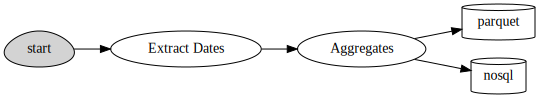

In [6]:
# Define the Transactions FeatureSet
transaction_set = fs.FeatureSet("transactions", 
                                 entities=[fs.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

# Get FeatureSet computation graph
transaction_graph = transaction_set.graph

# Add the custom `DateExtractor` step 
# to the computation graph
transaction_graph\
    .to(
        class_name='DateExtractor', 
        name='Extract Dates', 
        parts = ['hour', 'day_of_week'],
        timestamp_col = 'timestamp',
    )

# Add multiple aggregations on multiple time windows
windows = ['2h', '12h', '24h']
transaction_set.add_aggregation(name=f'amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=windows,
                                period='1h')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# User our loaded DF as the datasource and ingest it through
# the define pipeline
resp = fs.ingest(transaction_set, data, 
                 infer_options=fs.InferOptions.default())

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

Now that we ingested our data through the feature set, we can view the transformed data:

In [7]:
resp.head()

,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_avg_2h,...,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C169274898,5.0,15.0,26.0,44.74,44.74,62.05,120.77,393.54,795.31,24.154,...,28007,28007,es_transportation,24.35,0,2021-06-06 19:20:38.842886919,M1823072687,4247ffa2947840f286f5904af4195c2d,19,6
C1914057832,2.0,13.0,24.0,81.45,137.33,137.33,92.96,427.88,691.18,46.480,...,28007,28007,es_transportation,11.51,0,2021-06-06 19:49:15.636161415,M1823072687,7c990c9b672a48fabf0c3e46754d7e44,19,6
C1516302826,1.0,1.0,1.0,52.18,52.18,52.18,52.18,52.18,52.18,52.180,...,28007,28007,es_wellnessandbeauty,52.18,0,2021-06-08 10:38:21.334600699,M1535107174,5b556624a9604d3c9ababbdfd7712c77,10,1
C399389739,1.0,1.0,14.0,19.47,19.47,58.89,19.47,19.47,458.39,19.470,...,28007,28007,es_transportation,19.47,0,2021-06-07 20:08:17.110839503,M1823072687,af64e8882c0d42aeb54d16e5504b1f61,20,0
C146494822,1.0,2.0,8.0,57.31,68.38,68.38,57.31,125.69,298.19,57.310,...,28007,28007,es_transportation,57.31,0,2021-06-07 15:57:02.103738433,M1823072687,0afd061cfc8a4a38a8711232d1b07f99,15,0


### Load and define the Events Set

We will now handle our `events` feature set.
This feature set will contain all the user events related to the platform such as account logins, details or password change.

The first step will be to load our publicly available dataset:

In [8]:
# Load the events dataset
events = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Align the samples timestamp for the past 2 days
# so we can see that latest aggregations in 
# our online feature vectors
events = adjust_data_timespan(events)
events.head()

,source,event,timestamp
0,C1974668487,details_change,2021-06-07 22:01:29.596657086
1,C1973547259,login,2021-06-08 01:03:03.853797508
2,C515668508,login,2021-06-07 21:36:10.134974302
3,C1721541488,details_change,2021-06-07 23:43:40.244191221
4,C394979408,password_change,2021-06-08 01:21:28.291614667


Now we will define the events feature set.
This is a pretty straight forward pipeline in which we only one hot encode the event categories and save the data to the default targets.

In [9]:
from mlrun.feature_store.steps import OneHotEncoder

events_set = fs.FeatureSet("events",
                           entities=[fs.Entity("source")],
                           timestamp_key='timestamp', 
                           description="events feature set")
events_set_graph = events_set.spec.graph

events_mapping = {'event': list(events.event.unique())}

events_set_graph.\
    to(OneHotEncoder(mapping=events_mapping), name='encode_event_types')

events_set.set_targets()

events_df=fs.ingest(events_set, events)
events_df.head()

,event_details_change,event_login,event_password_change,timestamp
source,,,,
C1974668487,1,0,0,2021-06-07 22:01:29.596657086
C1973547259,0,1,0,2021-06-08 01:03:03.853797508
C515668508,0,1,0,2021-06-07 21:36:10.134974302
C1721541488,1,0,0,2021-06-07 23:43:40.244191221
C394979408,0,0,1,2021-06-08 01:21:28.291614667


### Define the Parties Set

Now lets define the `parties` feature set.
This feature set includes specific user analysis including gender and their cateogry history.

We will define the pipeline with mapping the gender values to fit our needs. Then we one hot encode the gender and categories data and aggregate the categories over the past 14 days.

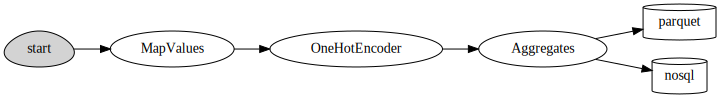

In [10]:
from mlrun.feature_store.steps import MapValues

# Define the `parties` FeatureSet
parties_set = fs.FeatureSet("parties", entities=[fs.Entity("source")], description="involved parties dataset")

# Extract the parties computation graph
parties_set_graph = parties_set.spec.graph

# Define and add the value mapping and one hot encoder mappings
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(data.gender.unique())}

# Add the value mapping and one hot encoding steps to the graph
parties_set_graph\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

# Add the category aggregations
for category in main_categories:
    parties_set.add_aggregation(name=category,column=f'category_{category}', operations=['count'], windows=['14d'], period='1d')

# Add the default data targets
parties_set.set_targets()

# Plot the featuer set to inspect the different steps
parties_set.plot(rankdir="LR", with_targets=True)

After defining the `parties` feature set lets ingest the data and verify we created all the expected features

In [11]:
parties_df=fs.ingest(parties_set, data)
parties_df.columns

Index(['es_transportation_count_14d', 'es_health_count_14d',
       'es_otherservices_count_14d', 'es_food_count_14d',
       'es_hotelservices_count_14d', 'es_barsandrestaurants_count_14d',
       'es_tech_count_14d', 'es_sportsandtoys_count_14d',
       'es_wellnessandbeauty_count_14d', 'es_hyper_count_14d',
       'es_fashion_count_14d', 'es_home_count_14d', 'es_contents_count_14d',
       'es_travel_count_14d', 'es_leisure_count_14d', 'age_mapped', 'step',
       'age', 'gender_F', 'gender_M', 'gender_E', 'gender_U', 'zipcodeOri',
       'zipMerchant', 'category_es_transportation', 'category_es_health',
       'category_es_otherservices', 'category_es_food',
       'category_es_hotelservices', 'category_es_barsandrestaurants',
       'category_es_tech', 'category_es_sportsandtoys',
       'category_es_wellnessandbeauty', 'category_es_hyper',
       'category_es_fashion', 'category_es_home', 'category_es_contents',
       'category_es_travel', 'category_es_leisure', 'amount', 'fraud

### Create a labels dataset for model training

This feature set contains the label for the fraud demo, it will be ingested directly to the default targets without any changes

In [12]:
# Extract the labels from the available data
labels = data[['fraud','source','timestamp']].copy()
labels = labels.rename(columns={"fraud": "label"})
labels['label'] = labels['label'].astype(int)

# We save the data as a CSV to show how you can
# easily ingest or infer the data's metadata
# directly from the file
labels_filepath = os.path.join(data_path, 'labels.csv')
labels.to_csv(labels_filepath)

# Define the `labels` feature set
labels_set = fs.FeatureSet("labels", 
                           entities=[fs.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels")

# Add the default save targets
labels_set.set_targets()

# Infer the feature set's metadata directly
# from the saved CSV file
df = fs.infer(labels_set, labels_filepath)

In [13]:
# Ingest the labels feature set
df = fs.ingest(labels_set, labels)
df.head()

,label,timestamp
source,,
C169274898,0,2021-06-06 19:20:38.842886919
C1914057832,0,2021-06-06 19:49:15.636161415
C1516302826,0,2021-06-08 10:38:21.334600699
C399389739,0,2021-06-07 20:08:17.110839503
C146494822,0,2021-06-07 15:57:02.103738433
